<a href="https://colab.research.google.com/github/chinmayeekelkar1/cs445/blob/main/CS445_Proj2_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time

# modify to where you store your project data including utils.py
datadir = "/content/drive/My Drive/proj2_CK/"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

In [ ]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [137]:
# def quilt_random(sample, out_size, patch_size):
#     """
#     Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

#     :param sample: numpy.ndarray   The image you read from sample directory
#     :param out_size: int            The width of the square output image
#     :param patch_size: int          The width of the square sample patch
#     :return: numpy.ndarray
#     """

def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    sample_height = sample.shape[0]
    channels = sample.shape[2] if len(sample.shape) == 3 else 1
    output_image = np.zeros((out_size, out_size, channels), dtype=sample.dtype)

    for row in range(0, out_size, patch_size):
        for col in range(0, out_size, patch_size):
            patch_height = min(patch_size, out_size - row)
            patch_width = min(patch_size, out_size - col)
            rand_y = np.random.randint(0, sample_height - patch_height + 1)
            rand_x = np.random.randint(0, sample_height - patch_width + 1)
            patch = sample[rand_y:rand_y + patch_height, rand_x:rand_x + patch_width, :]
            output_image[row:row + patch_height, col:col + patch_width, :] = patch

    return output_image


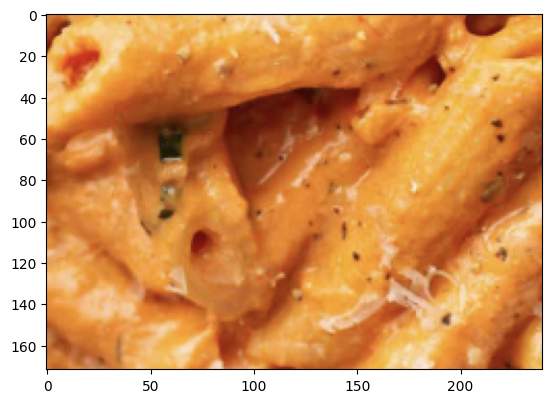

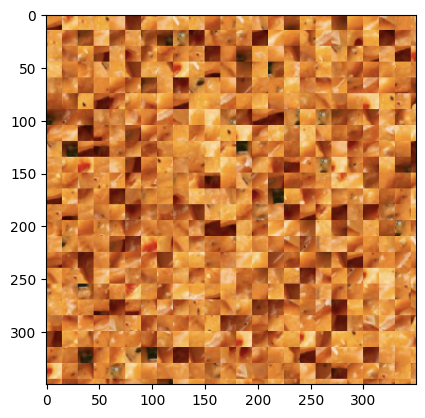

In [138]:
# sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
# sample_img_fn = 'samples/crochet.png' # feel free to change
sample_img_fn = 'samples/pasta.png' # feel free to change

sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 350  # change these parameters as needed
patch_size = 15
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [ ]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    def ssd_patch(template, mask, texture):
        squared_diff = (mask * template) ** 2
        filter1 = cv2.filter2D(texture, ddepth=-1, kernel=mask * template)
        filter2 = cv2.filter2D(texture ** 2, ddepth=-1, kernel=mask)
        ssd_cost = squared_diff.sum() - 2 * filter1.sum() + filter2.sum()
        return ssd_cost

    def choose_sample(cost_image, tol):
        indices = np.argpartition(cost_image.flatten(), tol)[:tol]
        coordinates = np.column_stack(np.unravel_index(indices, cost_image.shape))
        chosen_coord = coordinates[np.random.choice(tol)]
        return tuple(chosen_coord)

    output_image = np.zeros((out_size, out_size, sample.shape[2]), dtype=np.uint8)

    i, j = np.random.randint(0, sample.shape[0] - patch_size), np.random.randint(0, sample.shape[1] - patch_size)
    output_image[:patch_size, :patch_size] = sample[i:i + patch_size, j:j + patch_size]

    for i in range(0, out_size - patch_size, patch_size - overlap):
        for j in range(0, out_size - patch_size, patch_size - overlap):
            mask = np.zeros((patch_size, patch_size, sample.shape[2]), dtype=np.uint8)
            mask[:overlap, :] = 1
            mask[:, :overlap] = 1

            template = output_image[i:i + patch_size, j:j + patch_size]
            ssd_cost = ssd_patch(template, mask, sample)
            x, y = choose_sample(ssd_cost, tol)
            fit_patch = sample[x:x + patch_size, y:y + patch_size]

            output_image[i:i + patch_size, j:j + patch_size] = fit_patch

    return output_image


In [ ]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [ ]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [ ]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    def ssd_patch(template, mask, texture):
        squared_diff = (mask * template) ** 2
        filter1 = np.sum(mask * template * texture, axis=2)
        filter2 = np.sum(texture ** 2 * mask, axis=2)
        ssd_cost = squared_diff.sum(axis=2) - 2 * filter1 + filter2
        return ssd_cost

    def choose_sample(cost_image, tol):
        indices = np.argpartition(cost_image.flatten(), tol)[:tol]
        coordinates = np.column_stack(np.unravel_index(indices, cost_image.shape))
        chosen_coord = coordinates[np.random.choice(tol)]
        return tuple(chosen_coord)

    def compute_seam(template, fit_patch, mask):
        bnd_cost = np.sum((fit_patch - template) ** 2, axis=2)
        cut_mask = cut(bnd_cost)
        return np.logical_and(mask, cut_mask)

    output_image = np.zeros((out_size, out_size, sample.shape[2]), dtype=np.uint8)

    i, j = np.random.randint(0, sample.shape[0] - patch_size), np.random.randint(0, sample.shape[1] - patch_size)
    output_image[:patch_size, :patch_size] = sample[i:i + patch_size, j:j + patch_size]

    for i in range(0, out_size - patch_size, patch_size - overlap):
        for j in range(0, out_size - patch_size, patch_size - overlap):
            mask = np.zeros((patch_size, patch_size, sample.shape[2]), dtype=np.uint8)
            mask[:overlap, :] = 1
            mask[:, :overlap] = 1

            template = output_image[i:i + patch_size, j:j + patch_size]
            ssd_cost = ssd_patch(template, mask, sample)
            x, y = choose_sample(ssd_cost, tol)
            fit_patch = sample[x:x + patch_size, y:y + patch_size]

            seam_vertical = compute_seam(template, fit_patch, mask)
            seam_horizontal = compute_seam(template.transpose(1, 0, 2), fit_patch.transpose(1, 0, 2), mask.transpose(1, 0, 2))

            final_seam = np.logical_and(seam_vertical, seam_horizontal.transpose(1, 0))

            output_image[i:i + patch_size, j:j + patch_size] = (1 - final_seam) * template + final_seam * fit_patch

    return output_image


In [ ]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 100  # change these parameters as needed
patch_size = 50
overlap = 50
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)

if res is not None:
    plt.figure(figsize=(15,15))
    print('hello')
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [ ]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding with texture transfer.
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """

    def ssd_patch(template, mask, texture, patch_size):
        squared_diff = (mask * template) ** 2
        filter1 = np.sum(mask * template * texture, axis=2)
        filter2 = np.sum(texture ** 2 * mask, axis=2)
        ssd_cost = squared_diff.sum(axis=2) - 2 * filter1 + filter2
        return ssd_cost

    def choose_sample(cost_image, tol, patch_size):
        indices = np.argpartition(cost_image.flatten(), tol)[:tol]
        coordinates = np.column_stack(np.unravel_index(indices, cost_image.shape))
        chosen_coord = coordinates[np.random.choice(tol)]
        return tuple(chosen_coord)

    def compute_seam(template, fit_patch, mask):
        bnd_cost = np.sum((fit_patch - template) ** 2, axis=2)
        cut_mask = cut(bnd_cost)
        return np.logical_and(mask, cut_mask)

    def transfer_texture(target_patch, source_patch, guidance_patch, alpha):
        return alpha * (target_patch - guidance_patch) + (1 - alpha) * source_patch

    output_image = np.zeros((guidance_im.shape[0], guidance_im.shape[1], sample.shape[2]), dtype=np.uint8)

    for i in range(0, guidance_im.shape[0] - patch_size, patch_size - overlap):
        for j in range(0, guidance_im.shape[1] - patch_size, patch_size - overlap):
            mask = np.zeros((patch_size, patch_size, sample.shape[2]), dtype=np.uint8)
            mask[:overlap, :] = 1
            mask[:, :overlap] = 1

            template = output_image[i:i + patch_size, j:j + patch_size]
            ssd_cost = ssd_patch(template, mask, sample, patch_size)
            x, y = choose_sample(ssd_cost, tol, patch_size)
            fit_patch = sample[x:x + patch_size, y:y + patch_size]

            seam_vertical = compute_seam(template, fit_patch, mask)
            seam_horizontal = compute_seam(template.transpose(1, 0, 2), fit_patch.transpose(1, 0, 2), mask.transpose(1, 0, 2))

            final_seam = np.logical_and(seam_vertical, seam_horizontal.transpose(1, 0))

            guidance_patch = guidance_im[i:i + patch_size, j:j + patch_size]
            transferred_patch = transfer_texture(fit_patch, template, guidance_patch, alpha)

            output_image[i:i + patch_size, j:j + patch_size] = (1 - final_seam) * template + final_seam * transferred_patch

    return output_image


In [ ]:
# load/process appropriate input texture and guidance images

patch_size = 35
overlap = 11
tol = 5
alpha = 0.2
guidance_img = 'samples/text_small.jpg'
texture_img = 'samples/texture.png'
texture_img = cv2.imread('samples/texture.png')
guidance_img = cv2.imread('samples/text_small.jpg')
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(15,15))
plt.imshow(res)
plt.show()



### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).